In [1]:
#!pip install tensorflow


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Epoch 1/100


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4839 - loss: 0.7270 - val_accuracy: 0.1579 - val_loss: 0.8182
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6046 - loss: 0.6548 - val_accuracy: 0.0088 - val_loss: 0.9457
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5796 - loss: 0.6893 - val_accuracy: 0.0526 - val_loss: 0.9046
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5767 - loss: 0.6813 - val_accuracy: 0.0702 - val_loss: 0.8903
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5708 - loss: 0.6708 - val_accuracy: 0.0789 - val_loss: 0.8732
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6126 - loss: 0.6550 - val_accuracy: 0.0965 - val_loss: 0.8859

Neural Network Train Accuracy: 0.5387
Neural Network Test Accuracy: 0.6600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.70      0.90      0.79     

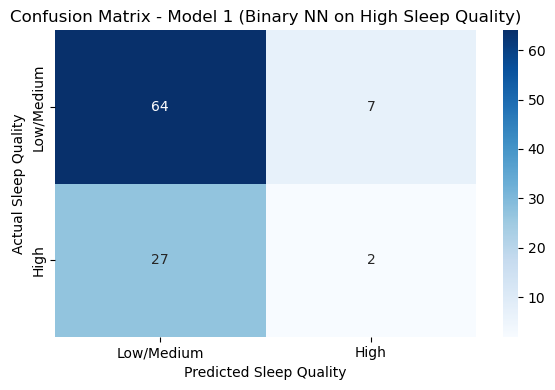

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# -----------------------------
# Load and Preprocess Dataset
# -----------------------------
df = pd.read_csv("student_sleep_patterns.csv")

# Stratified train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Bin Sleep_Quality into 3 categories
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0 = Low, 1 = Medium, 2 = High
train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Create binary label: 1 if High sleep quality, 0 otherwise
train_df['Sleep_Quality_Binary'] = train_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)
test_df['Sleep_Quality_Binary'] = test_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)

# Drop Student_ID if exists
for df_ in [train_df, test_df]:
    df_.drop(columns=[col for col in ['Student_ID'] if col in df_.columns], inplace=True)

# Encode categorical columns
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Separate features and target
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_train = train_df['Sleep_Quality_Binary']
X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_test = test_df['Sleep_Quality_Binary']

# Standardize for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral Clustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Use RandomForestClassifier to mimic clustering for test set
from sklearn.ensemble import RandomForestClassifier
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)
test_clusters = rf_cluster.predict(X_test)

# Add cluster as a new feature
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Apply SMOTE to balance binary classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# -----------------------------
# Train Neural Network
# -----------------------------

# Standardize all features for NN
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train_resampled)
X_test_scaled_all = scaler_all.transform(X_test)

# Define NN architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled_all.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train NN
history = model.fit(
    X_train_scaled_all, y_train_resampled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# Evaluation
# -----------------------------

# Accuracy on training and test sets
train_loss, train_acc = model.evaluate(X_train_scaled_all, y_train_resampled, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled_all, y_test, verbose=0)
print(f"\nNeural Network Train Accuracy: {train_acc:.4f}")
print(f"Neural Network Test Accuracy: {test_acc:.4f}")

# Predict and evaluate
y_test_pred_prob = model.predict(X_test_scaled_all).flatten()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Neural Network Test RMSE: {test_rmse:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Correct labels based on your binary target
labels = ['Low/Medium', 'High']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sleep Quality')
plt.ylabel('Actual Sleep Quality')
plt.title('Confusion Matrix - Model 1 (Binary NN on High Sleep Quality)')

# Save the plot
plt.tight_layout()
plt.savefig("Model1ConfusionMatrix.png")
plt.show()



C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Epoch 1/100


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4589 - loss: 0.7929 - val_accuracy: 0.4386 - val_loss: 0.7412
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5224 - loss: 0.7015 - val_accuracy: 0.0526 - val_loss: 0.9183
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5754 - loss: 0.6890 - val_accuracy: 0.0351 - val_loss: 0.9725
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6045 - loss: 0.6726 - val_accuracy: 0.0263 - val_loss: 0.9995
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6231 - loss: 0.6588 - val_accuracy: 0.0526 - val_loss: 0.9766
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6236 - loss: 0.6465 - val_accuracy: 0.0614 - val_loss: 0.9529

Neural Network (Selected Features) - Train Accuracy: 0.5264
Neural Network (Selected Features) - Test Accuracy: 0.5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Classification Report (Test):
              precision    recall  f1-score   support

     

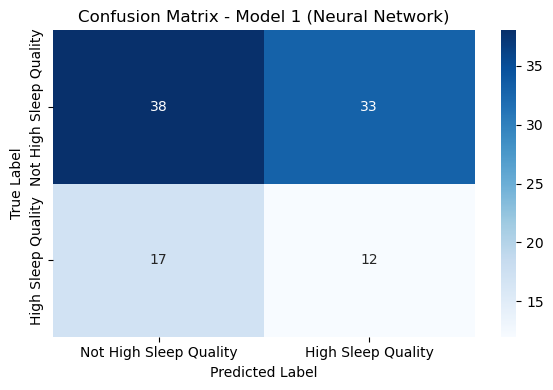

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# -----------------------------
# Load and Preprocess Dataset
# -----------------------------
df = pd.read_csv("student_sleep_patterns.csv")

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]
train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

train_df['Sleep_Quality_Binary'] = train_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)
test_df['Sleep_Quality_Binary'] = test_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)

for df_ in [train_df, test_df]:
    df_.drop(columns=[col for col in ['Student_ID'] if col in df_.columns], inplace=True)

cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_train = train_df['Sleep_Quality_Binary']
X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_test = test_df['Sleep_Quality_Binary']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)
test_clusters = rf_cluster.predict(X_test)

X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# -----------------------------
# Get top-k best features from RF
# -----------------------------
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)
random_search.fit(X_train_resampled, y_train_resampled)

best_rf = random_search.best_estimator_
importances = best_rf.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Try different k to find best feature subset
test_accuracies = []
for k in range(1, len(features) + 1):
    top_features = feat_imp_df['Feature'].iloc[:k].tolist()
    rf_top = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
    rf_top.fit(X_train[top_features], y_train)
    y_test_pred_k = rf_top.predict(X_test[top_features])
    acc = accuracy_score(y_test, y_test_pred_k)
    test_accuracies.append(acc)

best_k = np.argmax(test_accuracies) + 1
best_features = feat_imp_df['Feature'].iloc[:best_k].tolist()

# -----------------------------
# Train NN using best_features
# -----------------------------
X_train_nn = X_train_resampled[best_features].copy()
X_test_nn = X_test[best_features].copy()

scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_nn_scaled, y_train_resampled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# Evaluation
# -----------------------------
train_loss, train_acc = model.evaluate(X_train_nn_scaled, y_train_resampled, verbose=0)
test_loss, test_acc = model.evaluate(X_test_nn_scaled, y_test, verbose=0)
print(f"\nNeural Network (Selected Features) - Train Accuracy: {train_acc:.4f}")
print(f"Neural Network (Selected Features) - Test Accuracy: {test_acc:.4f}")

y_test_pred_prob = model.predict(X_test_nn_scaled).flatten()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"NN Test RMSE: {test_rmse:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not High Sleep Quality', 'High Sleep Quality']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 1 (Neural Network)')

# Save
plt.tight_layout()
plt.savefig("Model2ConfusionMatrix.png")
plt.show()



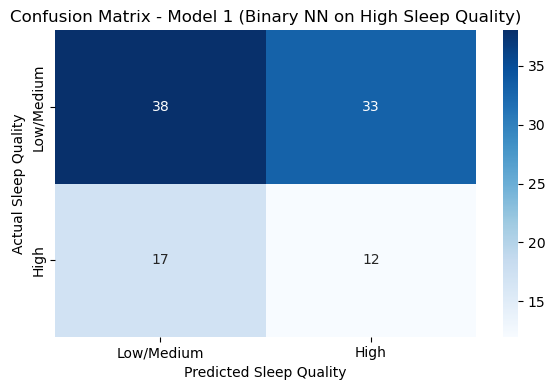

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Correct labels based on your binary target
labels = ['Low/Medium', 'High']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sleep Quality')
plt.ylabel('Actual Sleep Quality')
plt.title('Confusion Matrix - Model 1 (Binary NN on High Sleep Quality)')

# Save the plot
plt.tight_layout()
plt.savefig("Model1ConfusionMatrix.png")
plt.show()

In [5]:
#%pip install keras-tuner --upgrade


C:\Users\HP\AppData\Local\Temp\ipykernel_6736\3385665422.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from my_dir\sleep_quality_nn_tuning\tuner0.json
Best units_1: 224
Best dropout_1: 0.5
Best num_layers: 1
Best learning_rate: 0.00011891270671542787
Epoch 1/100


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3937 - loss: 0.8447 - val_accuracy: 0.9386 - val_loss: 0.5914
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3967 - loss: 0.7921 - val_accuracy: 0.7807 - val_loss: 0.6452
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4546 - loss: 0.7805 - val_accuracy: 0.5175 - val_loss: 0.6957
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4780 - loss: 0.7241 - val_accuracy: 0.1842 - val_loss: 0.7430
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5276 - loss: 0.7173 - val_accuracy: 0.0439 - val_loss: 0.7853
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5190 - loss: 0.7180 - val_accuracy: 0.0088 - val_loss: 0.8195
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5029 - loss: 0.7137 - val_accuracy: 0.0000e+00 - val_loss: 0.8489
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5601 - loss: 0.6855 - val_accuracy: 0.0000e+00 - val_

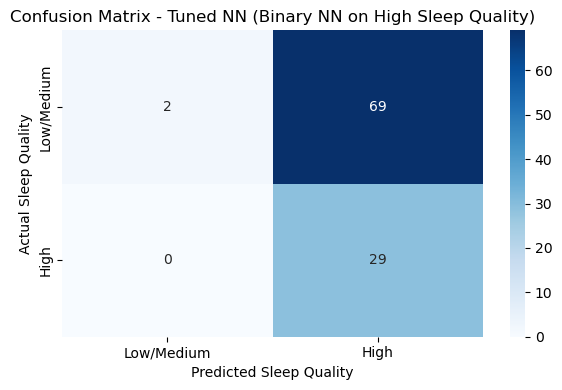

In [6]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score # Import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping


def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_dim=X_train_scaled_all.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Tune number of hidden layers between 1 and 3
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=16, max_value=128, step=16),
            activation='relu'
        ))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', 0.1, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='sleep_quality_nn_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

tuner.search(
    X_train_scaled_all, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units_1: {best_hp.get('units_1')}")
print(f"Best dropout_1: {best_hp.get('dropout_1')}")
print(f"Best num_layers: {best_hp.get('num_layers')}")
print(f"Best learning_rate: {best_hp.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hp)

# Train the best model
history = best_model.fit(
    X_train_scaled_all, y_train_resampled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the tuned model on test data
y_pred_prob = best_model.predict(X_test_scaled_all).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nTuned Neural Network Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_prob)
print("Tuned AUC-ROC Score:", round(auc_score, 4))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Correct labels based on your binary target
labels = ['Low/Medium', 'High']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sleep Quality')
plt.ylabel('Actual Sleep Quality')
plt.title('Confusion Matrix - Tuned NN (Binary NN on High Sleep Quality)')

# Save the plot
plt.tight_layout()
plt.savefig("Model3ConfusionMatrix.png")
plt.show()

In [7]:
!pip install keras-tuner -q

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

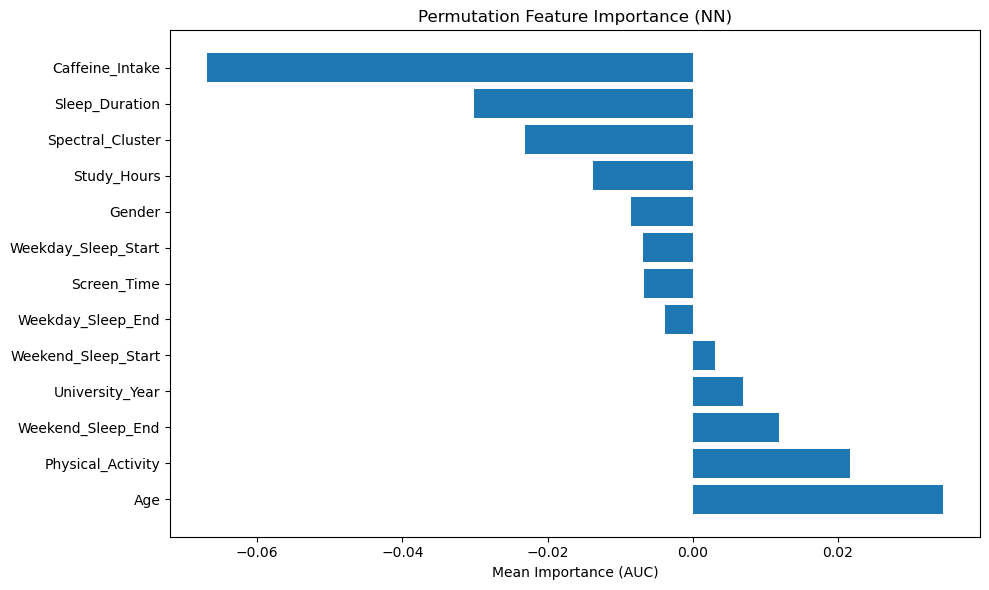

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score # Import roc_auc_score

# Create a wrapper function for the Keras model's predict method
def predict_proba_wrapper(model, X):
    # Keras predict returns probabilities directly for sigmoid output
    return model.predict(X)

# Use the scaled test data that the tuned model was evaluated on
X_input = X_test_scaled_all

perm = permutation_importance(
    estimator=best_model,
    X=X_input,
    y=y_test,
    n_repeats=10,
    # Remove the repeated scoring parameter
    # scoring='roc_auc',
    random_state=42,
    # Use a custom scorer for roc_auc that uses model.predict
    scoring = lambda estimator, X, y: roc_auc_score(y, estimator.predict(X))
)

# Get sorted indices
sorted_idx = perm.importances_mean.argsort()[::-1]
# Use original feature names from X_test if available, or create generic ones
# Need to get feature names from X_test_scaled_all's original source, which is X_test_resampled_scaled in the previous cell
# Since X_train_resampled_scaled was derived from X_train_resampled, we can use columns from X_train_resampled
feature_names = X_train_resampled.columns


# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm.importances_mean[sorted_idx]) # Plot in descending order
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx]) # Match y-ticks to sorted data
plt.xlabel("Mean Importance (AUC)") # Update label
plt.title("Permutation Feature Importance (NN)")
plt.tight_layout()
plt.savefig("permutation_feature_importance_nn.png", dpi=300)
plt.show()